# Jaguar Re-Identification Baseline with MegaDescriptor and ArcFace

This notebook demonstrates a complete pipeline for training a jaguar re-identification model using MegaDescriptor embeddings and ArcFace loss. The goal is to learn embeddings that place images of the same jaguar close together and images of different jaguars far apart.

## Overview

1. **Data Loading**: Load training images and create a stratified train/validation split
2. **MegaDescriptor**: Extract baseline embeddings using a pre-trained vision transformer
3. **Visualization**: Use MDS to visualize embeddings before and after fine-tuning
4. **ArcFace Training**: Fine-tune embeddings using angular margin loss
5. **Submission**: Generate predictions for the competition test set

## Key Concepts

**MegaDescriptor** is a vision transformer trained on wildlife re-identification datasets. It produces 1536-dimensional embeddings that capture visual features useful for distinguishing individual animals.

**ArcFace (Additive Angular Margin Loss)** is a metric learning technique that:
- Projects embeddings onto a unit hypersphere (L2 normalized)
- Optimizes angular distances between class centers
- Adds an angular margin to improve class separation

The combination allows us to fine-tune MegaDescriptor for our specific jaguar dataset.

## 1. Setup and Configuration

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import timm
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
import math
import wandb
from dotenv import load_dotenv

# Load environment variables from .env file
# The .env file should contain: WANDB_API_KEY, WANDB_PROJECT, HF_TOKEN
env_path = Path("../../.env")
if env_path.exists():
    load_dotenv(env_path)
    print(f"Loaded environment variables from {env_path}")
else:
    print(f"Warning: {env_path} not found. Set WANDB_API_KEY and HF_TOKEN manually.")


from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
os.environ["HF_TOKEN"]= user_secrets.get_secret("hf_api")
os.environ["WANDB_API_KEY"] = user_secrets.get_secret("wandb_api")


# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"PyTorch version: {torch.__version__}")
print(f"timm version: {timm.__version__}")

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

PyTorch version: 2.8.0+cu126
timm version: 1.0.20


In [2]:
# Device configuration
# MPS (Metal Performance Shaders) provides GPU acceleration on Apple Silicon (if you want to run this notebook locally on your MacBook)
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Device: {device}")

Using CUDA GPU
Device: cuda


In [3]:
# Configuration
config = {
    # Paths
    "data_dir": Path("/kaggle/input/jaguar-re-id"),
    "checkpoint_dir": Path("checkpoints"),
    
    # Model
    "megadescriptor_model": "hf-hub:BVRA/MegaDescriptor-L-384",
    "input_size": 384,
    "embedding_dim": 256,
    "hidden_dim": 512,
    
    # ArcFace
    "arcface_margin": 0.5,
    "arcface_scale": 64.0,
    "dropout": 0.3,
    
    # Training
    "batch_size": 32,
    "learning_rate": 1e-4,
    "weight_decay": 1e-4,
    "num_epochs": 50,
    "patience": 10,
    "val_split": 0.2,
    
    # Reproducibility
    "seed": RANDOM_SEED,
}

# Create checkpoint directory
config["checkpoint_dir"].mkdir(exist_ok=True)

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Configuration:
  data_dir: /kaggle/input/jaguar-re-id
  checkpoint_dir: checkpoints
  megadescriptor_model: hf-hub:BVRA/MegaDescriptor-L-384
  input_size: 384
  embedding_dim: 256
  hidden_dim: 512
  arcface_margin: 0.5
  arcface_scale: 64.0
  dropout: 0.3
  batch_size: 32
  learning_rate: 0.0001
  weight_decay: 0.0001
  num_epochs: 50
  patience: 10
  val_split: 0.2
  seed: 42


In [4]:
# Initialize Weights and Biases for experiment tracking
# Key hyperparameters are tracked explicitly for easy filtering in W&B dashboard
wandb.login(key=os.environ["WANDB_API_KEY"])

wandb.init(
    project=os.getenv("WANDB_PROJECT", "jaguar-reid-baseline"),
    config={
        # Model architecture
        "megadescriptor_model": config["megadescriptor_model"],
        "embedding_dim": config["embedding_dim"],
        "hidden_dim": config["hidden_dim"],
        "dropout": config["dropout"],
        
        # ArcFace hyperparameters (critical for performance)
        "arcface_margin": config["arcface_margin"],
        "arcface_scale": config["arcface_scale"],
        
        # Training hyperparameters
        "batch_size": config["batch_size"],
        "learning_rate": config["learning_rate"],
        "weight_decay": config["weight_decay"],
        "num_epochs": config["num_epochs"],
        "patience": config["patience"],
        "val_split": config["val_split"],
        "seed": config["seed"],
    },
    name="megadescriptor-arcface-local",
)

print("W&B initialized. Key hyperparameters tracked:")
print(f"  Project: {os.getenv('WANDB_PROJECT', 'jaguar-reid-baseline')}")
print(f"  ArcFace margin: {config['arcface_margin']} ({config['arcface_margin'] * 180 / 3.14159:.1f}°)")
print(f"  ArcFace scale: {config['arcface_scale']}")
print(f"  Embedding dim: {config['embedding_dim']}")
print(f"  Dropout: {config['dropout']}")

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: antonioernestoruedatoicen (antonios-org) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


W&B initialized. Key hyperparameters tracked:
  Project: jaguar-reid-baseline
  ArcFace margin: 0.5 (28.6°)
  ArcFace scale: 64.0
  Embedding dim: 256
  Dropout: 0.3


## 2. Load and Prepare Data

We load the training data from `train.csv` which contains image filenames and their corresponding jaguar identity labels. The key challenge is creating a proper train/validation split:

**Stratified Split**: We ensure every jaguar identity appears in both the training and validation sets. This is critical because:
1. The model must learn to recognize all individuals during training
2. Validation mAP should reflect performance across all identities
3. Identities with few images still need representation in both sets

In [5]:
# Load training data
train_df = pd.read_csv(config["data_dir"] / "train.csv")

print(f"Training dataset:")
print(f"  Total images: {len(train_df)}")
print(f"  Unique identities: {train_df['ground_truth'].nunique()}")
print(f"\nSample rows:")
print(train_df.head())

# Analyze identity distribution
identity_counts = train_df['ground_truth'].value_counts()
print(f"\nIdentity distribution:")
print(f"  Min images per identity: {identity_counts.min()} ({identity_counts.idxmin()})")
print(f"  Max images per identity: {identity_counts.max()} ({identity_counts.idxmax()})")
print(f"  Mean images per identity: {identity_counts.mean():.1f}")

Training dataset:
  Total images: 1895
  Unique identities: 31

Sample rows:
         filename ground_truth
0  train_0001.png        Abril
1  train_0002.png        Abril
2  train_0003.png        Abril
3  train_0004.png       Akaloi
4  train_0005.png       Akaloi

Identity distribution:
  Min images per identity: 13 (Ipepo)
  Max images per identity: 183 (Marcela)
  Mean images per identity: 61.1


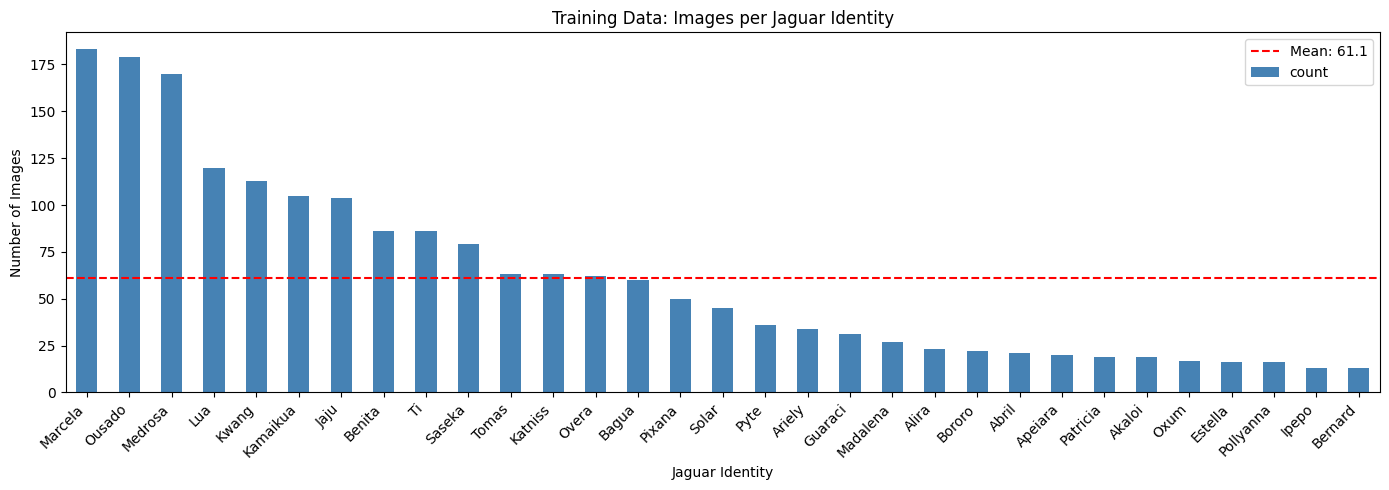

In [6]:
# Visualize identity distribution and log to W&B
fig, ax = plt.subplots(figsize=(14, 5))
identity_counts.plot(kind='bar', ax=ax, color='steelblue')
ax.set_xlabel('Jaguar Identity')
ax.set_ylabel('Number of Images')
ax.set_title('Training Data: Images per Jaguar Identity')
ax.axhline(y=identity_counts.mean(), color='red', linestyle='--', label=f'Mean: {identity_counts.mean():.1f}')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Log to W&B
wandb.log({"identity_distribution_full": wandb.Image(fig)})
plt.show()

# Identify identities that may need careful handling (few samples)
min_samples_for_split = 2  # Need at least 2 to split
low_sample_identities = identity_counts[identity_counts < min_samples_for_split]

if len(low_sample_identities) > 0:   
    print(f"\nWarning: {len(low_sample_identities)} identities have fewer than {min_samples_for_split} images")

Dataset split:
  Training:   1516 images (80%)
  Validation: 379 images (20%)

Identity coverage:
  Identities in training:   31
  Identities in validation: 31
  Overlap: 31
  All identities present in both sets


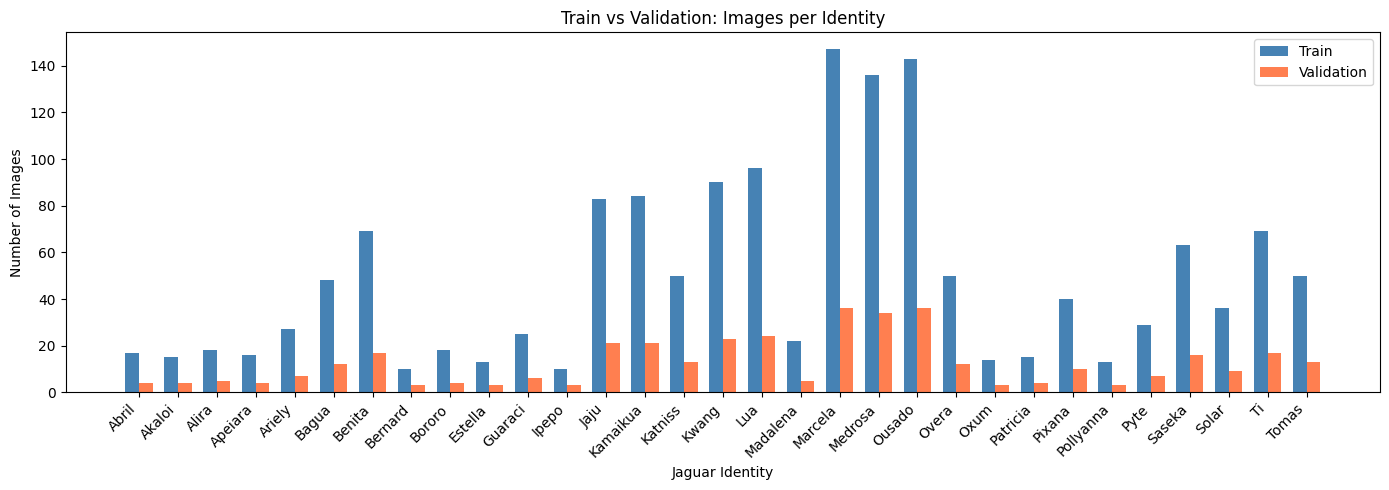


Logged identity distributions to W&B
  Train samples per identity: 10 - 147 (mean: 48.9)
  Val samples per identity: 3 - 36 (mean: 12.2)


In [7]:
# Create stratified train/validation split
# This ensures all identities appear in both sets

# Encode labels to integers
label_encoder = LabelEncoder()
train_df['label_encoded'] = label_encoder.fit_transform(train_df['ground_truth'])
num_classes = len(label_encoder.classes_)

# Stratified split: each identity's images are split proportionally
train_data, val_data = train_test_split(
    train_df,
    test_size=config["val_split"],
    random_state=config["seed"],
    stratify=train_df['ground_truth']  # Ensures proportional representation
)

print(f"Dataset split:")
print(f"  Training:   {len(train_data)} images ({100*(1-config['val_split']):.0f}%)")
print(f"  Validation: {len(val_data)} images ({100*config['val_split']:.0f}%)")

# Verify all identities are in both sets
train_identities = set(train_data['ground_truth'].unique())
val_identities = set(val_data['ground_truth'].unique())

print(f"\nIdentity coverage:")
print(f"  Identities in training:   {len(train_identities)}")
print(f"  Identities in validation: {len(val_identities)}")
print(f"  Overlap: {len(train_identities & val_identities)}")

if train_identities == val_identities:
    print("  All identities present in both sets")

# Log identity distributions to W&B
train_counts = train_data['ground_truth'].value_counts().sort_index()
val_counts = val_data['ground_truth'].value_counts().sort_index()

# Create a comparison table for W&B
distribution_df = pd.DataFrame({
    'identity': train_counts.index,
    'train_count': train_counts.values,
    'val_count': val_counts.values,
    'total_count': train_counts.values + val_counts.values,
    'train_ratio': train_counts.values / (train_counts.values + val_counts.values)
})

# Log table and summary stats to W&B
wandb.log({
    "identity_distribution_table": wandb.Table(dataframe=distribution_df),
    "num_identities": num_classes,
    "train_samples": len(train_data),
    "val_samples": len(val_data),
    "train_samples_per_identity": wandb.Histogram(train_counts.values),
    "val_samples_per_identity": wandb.Histogram(val_counts.values),
})

# Visualize train vs val distribution
fig, ax = plt.subplots(figsize=(14, 5))
width = 0.35
x = np.arange(len(train_counts))
ax.bar(x - width/2, train_counts.values, width, label='Train', color='steelblue')
ax.bar(x + width/2, val_counts.values, width, label='Validation', color='coral')
ax.set_xlabel('Jaguar Identity')
ax.set_ylabel('Number of Images')
ax.set_title('Train vs Validation: Images per Identity')
ax.set_xticks(x)
ax.set_xticklabels(train_counts.index, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
wandb.log({"train_val_distribution": wandb.Image(fig)})
plt.show()

print(f"\nLogged identity distributions to W&B")
print(f"  Train samples per identity: {train_counts.min()} - {train_counts.max()} (mean: {train_counts.mean():.1f})")
print(f"  Val samples per identity: {val_counts.min()} - {val_counts.max()} (mean: {val_counts.mean():.1f})")

## 3. Load MegaDescriptor Model

MegaDescriptor is a Vision Transformer (ViT-L/14) trained specifically for wildlife re-identification. It was trained on multiple species datasets and produces 1536-dimensional embeddings.

We use the `timm` library to load the pre-trained model from Hugging Face Hub.

In [8]:
# Load MegaDescriptor model
print("Loading MegaDescriptor-L-384 model...")
megadescriptor = timm.create_model(
    config["megadescriptor_model"],
    pretrained=True
)
megadescriptor.eval()
megadescriptor.to(device)

print(f"Model loaded successfully")
print(f"  Parameters: {sum(p.numel() for p in megadescriptor.parameters()):,}")

# Get the embedding dimension from the model
with torch.no_grad():
    dummy_input = torch.randn(1, 3, config["input_size"], config["input_size"]).to(device)
    dummy_output = megadescriptor(dummy_input)
    megadescriptor_dim = dummy_output.shape[1]
    print(f"  Embedding dimension: {megadescriptor_dim}")

Loading MegaDescriptor-L-384 model...


config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

Model loaded successfully
  Parameters: 195,198,516
  Embedding dimension: 1536


In [9]:
# Define preprocessing pipeline
# MegaDescriptor expects 384x384 images normalized with ImageNet statistics
preprocess = transforms.Compose([
    transforms.Resize((config["input_size"], config["input_size"])),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

print("Preprocessing pipeline configured:")
print(f"  Resize to: {config['input_size']}x{config['input_size']}")
print(f"  Normalization: ImageNet statistics")

Preprocessing pipeline configured:
  Resize to: 384x384
  Normalization: ImageNet statistics


In [10]:
@torch.no_grad()
def extract_embeddings(model, image_paths, batch_size=32, desc="Extracting embeddings"):
    """Extract embeddings for a list of image paths using MegaDescriptor."""
    model.eval()
    embeddings = []
    
    for i in tqdm(range(0, len(image_paths), batch_size), desc=desc):
        batch_paths = image_paths[i:i + batch_size]
        
        # Load and preprocess batch
        batch_tensors = []
        for path in batch_paths:
            try:
                img = Image.open(path).convert("RGB")
                tensor = preprocess(img)
                batch_tensors.append(tensor)
            except Exception as e:
                print(f"Error loading {path}: {e}")
                # Use zero tensor as fallback
                batch_tensors.append(torch.zeros(3, config["input_size"], config["input_size"]))
        
        # Stack and move to device
        batch_tensor = torch.stack(batch_tensors).to(device)
        
        # Get embeddings
        batch_emb = model(batch_tensor).cpu().numpy()
        embeddings.append(batch_emb)
    
    return np.vstack(embeddings)

print("Embedding extraction function defined")

Embedding extraction function defined


In [11]:
emb_dir = Path("/kaggle/working/embeddings")
emb_dir.mkdir(parents=True, exist_ok=True)

cache_path = emb_dir / "baseline_train_embeddings.npz"

# Extract baseline embeddings for training data
train_filenames = train_data["filename"].astype(str).tolist()
train_image_paths = [config["data_dir"] / "train/train" / fn for fn in train_filenames]

def _load_cached_embeddings(cache_path, expected_filenames):
    z = np.load(cache_path, allow_pickle=True)
    cached_embeddings = z["embeddings"]
    cached_filenames = z["filenames"].tolist() if isinstance(z["filenames"], np.ndarray) else list(z["filenames"])

    if len(cached_filenames) != len(expected_filenames):
        return None

    if set(cached_filenames) != set(expected_filenames):
        return None

    if cached_filenames == expected_filenames:
        return cached_embeddings

    idx = {fn: i for i, fn in enumerate(cached_filenames)}
    return np.stack([cached_embeddings[idx[fn]] for fn in expected_filenames], axis=0)

baseline_train_embeddings = None
if cache_path.exists():
    baseline_train_embeddings = _load_cached_embeddings(cache_path, train_filenames)
    if baseline_train_embeddings is not None:
        print(f"Loaded cached baseline embeddings from {cache_path}")
        print(f"Baseline embeddings shape: {baseline_train_embeddings.shape}")

if baseline_train_embeddings is None:
    print(f"Extracting baseline embeddings for {len(train_image_paths)} training images...")
    baseline_train_embeddings = extract_embeddings(
        megadescriptor,
        train_image_paths,
        batch_size=config["batch_size"]
    )
    np.savez_compressed(
        cache_path,
        embeddings=baseline_train_embeddings,
        filenames=np.array(train_filenames, dtype=object),
    )
    print(f"Saved baseline embeddings cache to {cache_path}")
    print(f"Baseline embeddings shape: {baseline_train_embeddings.shape}")


Extracting baseline embeddings for 1516 training images...


Extracting embeddings:   0%|          | 0/48 [00:00<?, ?it/s]

Saved baseline embeddings cache to /kaggle/working/embeddings/baseline_train_embeddings.npz
Baseline embeddings shape: (1516, 1536)


## 4. Visualize Baseline Embeddings with MDS

Multidimensional Scaling (MDS) projects high-dimensional embeddings to 2D while preserving pairwise distances. For embeddings on a hypersphere (L2-normalized), we use geodesic distances (arc length) rather than Euclidean distances.

This visualization shows how well MegaDescriptor separates different jaguars before any fine-tuning.

In [12]:
def compute_geodesic_distances(embeddings):
    """Compute geodesic (angular) distance matrix for normalized embeddings."""
    # Normalize embeddings to unit sphere
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    normalized = embeddings / norms
    
    # Compute cosine similarity
    cos_sim = np.clip(normalized @ normalized.T, -1.0, 1.0)
    
    # Convert to geodesic distance (arc length)
    geodesic_dist = np.arccos(cos_sim)
    
    return geodesic_dist


def visualize_embeddings_mds(embeddings, labels, title, max_samples=500):
    """Visualize embeddings using MDS with geodesic distances."""
    # Subsample if too many points (MDS is O(n^3))
    if len(embeddings) > max_samples:
        indices = np.random.choice(len(embeddings), max_samples, replace=False)
        embeddings = embeddings[indices]
        labels = labels[indices]
    
    # Compute geodesic distance matrix
    dist_matrix = compute_geodesic_distances(embeddings)
    
    # Apply MDS
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=RANDOM_SEED, normalized_stress='auto')
    coords_2d = mds.fit_transform(dist_matrix)
    
    # Create color mapping for identities
    unique_labels = np.unique(labels)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
    label_to_color = {label: colors[i] for i, label in enumerate(unique_labels)}
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    
    for label in unique_labels:
        mask = labels == label
        ax.scatter(
            coords_2d[mask, 0], 
            coords_2d[mask, 1],
            c=[label_to_color[label]],
            label=label,
            alpha=0.7,
            s=30
        )
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('MDS Dimension 1')
    ax.set_ylabel('MDS Dimension 2')
    
    # Legend outside plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()
    
    return fig

print("MDS visualization functions defined")

MDS visualization functions defined


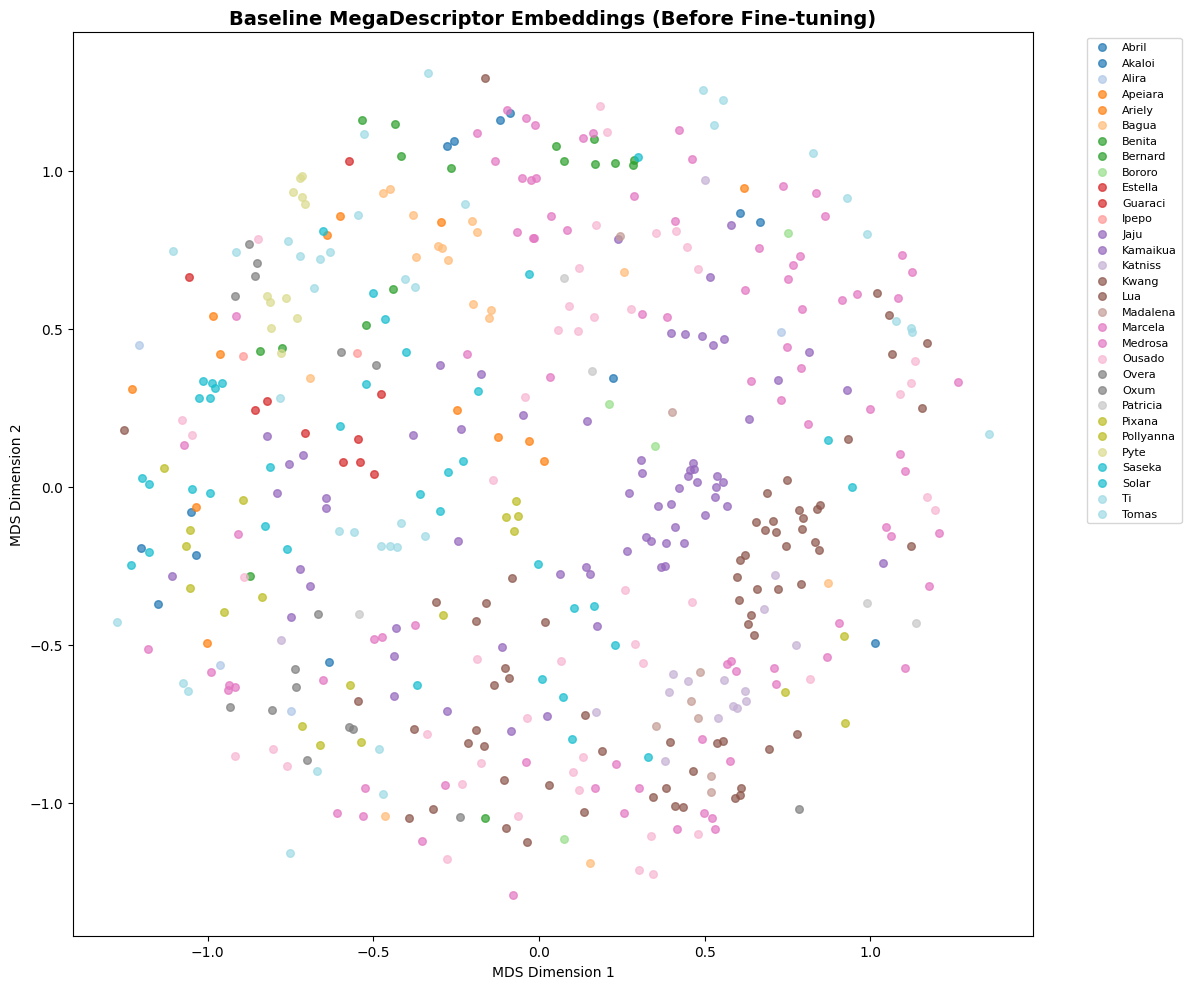

In [13]:
# Visualize baseline embeddings
train_labels = train_data['ground_truth'].values

fig_baseline = visualize_embeddings_mds(
    baseline_train_embeddings,
    train_labels,
    "Baseline MegaDescriptor Embeddings (Before Fine-tuning)"
)
plt.show()

# Log to W&B
wandb.log({"baseline_embeddings_mds": wandb.Image(fig_baseline)})

## 5. Define Model Architecture

We define two components:

1. **EmbeddingProjection**: Projects 1536-dim MegaDescriptor embeddings to 256-dim. This learned projection optimizes the embedding space for our specific jaguar dataset.

2. **ArcFaceLayer**: Implements Additive Angular Margin Loss. It:
   - Normalizes embeddings to unit length (projects to hypersphere)
   - Computes cosine similarity to class weight vectors
   - Adds angular margin to the ground truth class before softmax
   - Scales logits to sharpen the distribution

In [14]:
class EmbeddingProjection(nn.Module):
    """
    Projects MegaDescriptor embeddings to a lower-dimensional space.
    Architecture: input_dim -> hidden_dim -> output_dim
    """
    
    def __init__(self, input_dim=1536, hidden_dim=512, output_dim=256, dropout=0.3):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            
            nn.Linear(hidden_dim, output_dim),
            nn.BatchNorm1d(output_dim),
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.network(x)


class ArcFaceLayer(nn.Module):
    """
    ArcFace (Additive Angular Margin Loss) layer.
    
    The loss is computed as:
        L = -log(exp(s * cos(theta_y + m)) / (exp(s * cos(theta_y + m)) + sum(exp(s * cos(theta_j)))))
    
    where:
        - theta_y is the angle between embedding and ground truth class center
        - m is the angular margin (default 0.5 radians, about 28.6 degrees)
        - s is the feature scale (default 64)
    """
    
    def __init__(self, embedding_dim, num_classes, margin=0.5, scale=64.0):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_classes = num_classes
        self.margin = margin
        self.scale = scale
        
        # Learnable weight matrix (class prototypes on the hypersphere)
        self.weight = nn.Parameter(torch.FloatTensor(num_classes, embedding_dim))
        nn.init.xavier_uniform_(self.weight)
        
        # Pre-compute trigonometric values for efficiency
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)  # Threshold for numerical stability
        self.mm = math.sin(math.pi - margin) * margin
    
    def forward(self, embeddings, labels):
        """
        Args:
            embeddings: (batch_size, embedding_dim) - will be normalized
            labels: (batch_size,) - ground truth class indices
        
        Returns:
            logits: (batch_size, num_classes) - ArcFace logits for cross-entropy loss
        """
        # Normalize embeddings and weights to unit length
        embeddings = F.normalize(embeddings, p=2, dim=1)
        weight_norm = F.normalize(self.weight, p=2, dim=1)
        
        # Compute cosine similarity: cos(theta)
        cosine = F.linear(embeddings, weight_norm)
        cosine = cosine.clamp(-1.0, 1.0)
        
        # Compute sin(theta) from cos(theta)
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        
        # Compute cos(theta + m) using angle addition formula
        # cos(theta + m) = cos(theta)*cos(m) - sin(theta)*sin(m)
        phi = cosine * self.cos_m - sine * self.sin_m
        
        # Apply threshold to handle theta + m >= pi
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        
        # One-hot encode labels
        one_hot = torch.zeros(cosine.size(), device=embeddings.device)
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)
        
        # Apply margin only to ground truth class
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        
        # Scale logits
        output = output * self.scale
        
        return output


print("EmbeddingProjection and ArcFaceLayer defined")

EmbeddingProjection and ArcFaceLayer defined


In [15]:
class ArcFaceModel(nn.Module):
    """Complete model: Embedding Projection + ArcFace."""
    
    def __init__(self, input_dim, num_classes, embedding_dim=256, hidden_dim=512, margin=0.5, scale=64.0, dropout=0.3):
        super().__init__()
        self.embedding_net = EmbeddingProjection(
            input_dim=input_dim, 
            hidden_dim=hidden_dim,
            output_dim=embedding_dim,
            dropout=dropout
        )
        self.arcface = ArcFaceLayer(
            embedding_dim=embedding_dim, 
            num_classes=num_classes,
            margin=margin, 
            scale=scale
        )
    
    def forward(self, x, labels):
        """Forward pass for training (requires labels for ArcFace)."""
        embeddings = self.embedding_net(x)
        logits = self.arcface(embeddings, labels)
        return logits, embeddings
    
    def get_embeddings(self, x):
        """Get normalized embeddings for inference."""
        embeddings = self.embedding_net(x)
        return F.normalize(embeddings, p=2, dim=1)


# Create model
model = ArcFaceModel(
    input_dim=megadescriptor_dim,
    num_classes=num_classes,
    embedding_dim=config["embedding_dim"],
    hidden_dim=config["hidden_dim"],
    margin=config["arcface_margin"],
    dropout=config["dropout"],
).to(device)

print(f"ArcFace Model:")
print(f"  Input dim: {megadescriptor_dim}")
print(f"  Hidden dim: {config['hidden_dim']}")
print(f"  Embedding dim: {config['embedding_dim']}")
print(f"  Dropout: {config['dropout']}")
print(f"  Num classes: {num_classes}")
print(f"  ArcFace margin: {config['arcface_margin']}")

print(f"  ArcFace scale: {config['arcface_scale']}")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

ArcFace Model:
  Input dim: 1536
  Hidden dim: 512
  Embedding dim: 256
  Dropout: 0.3
  Num classes: 31
  ArcFace margin: 0.5
  ArcFace scale: 64.0
  Total parameters: 927,744


## 6. Prepare DataLoaders

We create PyTorch datasets from the pre-computed MegaDescriptor embeddings. This is more efficient than loading images during training since embedding extraction is the bottleneck.

In [16]:
# Extract embeddings for validation set
val_image_paths = [
    config["data_dir"] / "train/train" / filename 
    for filename in val_data['filename'].values
]

print(f"Extracting embeddings for {len(val_image_paths)} validation images...")
baseline_val_embeddings = extract_embeddings(
    megadescriptor, 
    val_image_paths, 
    batch_size=config["batch_size"]
)

print(f"Validation embeddings shape: {baseline_val_embeddings.shape}")

Extracting embeddings for 379 validation images...


Extracting embeddings:   0%|          | 0/12 [00:00<?, ?it/s]

Validation embeddings shape: (379, 1536)


In [17]:
class EmbeddingDataset(Dataset):
    """PyTorch Dataset for pre-computed embeddings."""
    
    def __init__(self, embeddings, labels):
        self.embeddings = torch.FloatTensor(embeddings)
        self.labels = torch.LongTensor(labels)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]


# Create datasets
train_dataset = EmbeddingDataset(
    baseline_train_embeddings, 
    train_data['label_encoded'].values
)
val_dataset = EmbeddingDataset(
    baseline_val_embeddings, 
    val_data['label_encoded'].values
)

# Create dataloaders
# Note: pin_memory=False for MPS compatibility
train_loader = DataLoader(
    train_dataset, 
    batch_size=config["batch_size"], 
    shuffle=True,
    num_workers=0,
    pin_memory=False
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=config["batch_size"], 
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

print(f"DataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Batch size: {config['batch_size']}")

DataLoaders created:
  Train batches: 48
  Val batches: 12
  Batch size: 32


## 7. Training Setup

We set up:
- **CrossEntropyLoss**: Standard classification loss (ArcFace returns logits)
- **AdamW optimizer**: Adam with decoupled weight decay
- **ReduceLROnPlateau scheduler**: Reduces learning rate when validation loss plateaus
- **Early stopping**: Stops training when no improvement for `patience` epochs

We also define a function to compute validation mAP, which simulates the competition metric on the validation set.

In [18]:
def compute_validation_map(model, val_embeddings, val_labels, label_encoder):
    """
    Compute identity-balanced mean Average Precision on validation set.
    
    This simulates the competition metric:
    1. For each query, rank all other images by cosine similarity
    2. Compute Average Precision based on where true matches appear
    3. Average APs within each identity, then average across identities
    """
    model.eval()
    
    with torch.no_grad():
        # Get fine-tuned embeddings
        val_tensor = torch.FloatTensor(val_embeddings).to(device)
        finetuned_emb = model.get_embeddings(val_tensor).cpu().numpy()
    
    # Compute cosine similarity matrix
    sim_matrix = cosine_similarity(finetuned_emb)
    np.fill_diagonal(sim_matrix, -1)  # Exclude self-similarity
    
    # Compute AP for each query
    query_aps = {}
    
    for query_idx in range(len(val_labels)):
        query_label = val_labels[query_idx]
        
        # Get similarities to all gallery images (excluding self)
        similarities = sim_matrix[query_idx]
        
        # True labels for gallery
        gallery_labels = val_labels.copy()
        is_match = (gallery_labels == query_label).astype(int)
        is_match[query_idx] = 0  # Exclude self
        
        # Sort by similarity descending
        sorted_indices = np.argsort(-similarities)
        sorted_matches = is_match[sorted_indices]
        
        # Compute Average Precision
        n_positives = sorted_matches.sum()
        if n_positives == 0:
            continue
        
        cumsum = np.cumsum(sorted_matches)
        precision_at_k = cumsum / np.arange(1, len(sorted_matches) + 1)
        ap = np.sum(precision_at_k * sorted_matches) / n_positives
        
        query_aps[query_idx] = (query_label, ap)
    
    # Group by identity and compute identity-balanced mAP
    identity_aps = {}
    for query_idx, (label, ap) in query_aps.items():
        if label not in identity_aps:
            identity_aps[label] = []
        identity_aps[label].append(ap)
    
    # Average within identity, then across identities
    identity_mean_aps = [np.mean(aps) for aps in identity_aps.values()]
    balanced_map = np.mean(identity_mean_aps)
    
    return balanced_map


print("Validation mAP function defined")

Validation mAP function defined


In [19]:
# Setup training components
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config["learning_rate"],
    weight_decay=config["weight_decay"]
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5,
)

print("Training components initialized:")
print(f"  Loss: CrossEntropyLoss")
print(f"  Optimizer: AdamW (lr={config['learning_rate']}, weight_decay={config['weight_decay']})")
print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)")

Training components initialized:
  Loss: CrossEntropyLoss
  Optimizer: AdamW (lr=0.0001, weight_decay=0.0001)
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=5)


In [20]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for embeddings, labels in pbar:
        embeddings, labels = embeddings.to(device), labels.to(device)
        
        # Forward pass
        logits, _ = model(embeddings, labels)
        loss = criterion(logits, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Metrics
        total_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.1f}%'})
    
    avg_loss = total_loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy


def validate_epoch(model, loader, criterion, device):
    """Validate for one epoch."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation', leave=False)
        for embeddings, labels in pbar:
            embeddings, labels = embeddings.to(device), labels.to(device)
            
            logits, _ = model(embeddings, labels)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.1f}%'})
    
    avg_loss = total_loss / len(loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy


print("Training and validation functions defined")

Training and validation functions defined


## 8. Training Loop

We train the model with:
- Validation loss and mAP computed each epoch
- Best model checkpointed based on lowest validation loss
- Early stopping if no improvement for `patience` epochs
- All metrics logged to Weights and Biases

In [21]:
# Training loop
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': [],
    'val_map': [], 'lr': []
}

best_val_loss = float('inf')
best_map = 0.0
patience_counter = 0
best_epoch = 0

print(f"Starting training for {config['num_epochs']} epochs...")
print("=" * 70)

for epoch in range(config['num_epochs']):
    print(f"\nEpoch {epoch+1}/{config['num_epochs']}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Compute validation mAP
    val_map = compute_validation_map(
        model, 
        baseline_val_embeddings, 
        val_data['ground_truth'].values,
        label_encoder
    )
    
    # Update scheduler
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_map'].append(val_map)
    history['lr'].append(current_lr)
    
    # Log to W&B
    wandb.log({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'val_map': val_map,
        'learning_rate': current_lr,
    })
    
    # Print summary
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.1f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.1f}%")
    print(f"  Val mAP:    {val_map:.4f} | LR: {current_lr:.2e}")
    
    # Checkpoint best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_map = val_map
        best_epoch = epoch + 1
        patience_counter = 0
        
        checkpoint_path = config["checkpoint_dir"] / "arcface_best.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'val_map': val_map,
            'config': config,
            'label_encoder_classes': label_encoder.classes_.tolist(),
            'num_classes': num_classes,
        }, checkpoint_path)
        
        print(f"  [New best model saved]")
    else:
        patience_counter += 1
        print(f"  No improvement. Patience: {patience_counter}/{config['patience']}")
    
    # Early stopping
    if patience_counter >= config['patience']:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\n" + "=" * 70)
print(f"Training complete!")
print(f"Best epoch: {best_epoch} (Val Loss: {best_val_loss:.4f}, Val mAP: {best_map:.4f})")

# Log best metrics as W&B summary for easy comparison across runs
wandb.run.summary["best_val_mAP"] = best_map
wandb.run.summary["best_val_loss"] = best_val_loss
wandb.run.summary["best_epoch"] = best_epoch
wandb.run.summary["total_epochs"] = len(history['train_loss'])

Starting training for 50 epochs...

Epoch 1/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 36.6027 | Train Acc: 0.0%
  Val Loss:   31.7337 | Val Acc:   0.0%
  Val mAP:    0.3516 | LR: 1.00e-04
  [New best model saved]

Epoch 2/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 31.4223 | Train Acc: 0.0%
  Val Loss:   26.8984 | Val Acc:   0.0%
  Val mAP:    0.3769 | LR: 1.00e-04
  [New best model saved]

Epoch 3/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 27.4678 | Train Acc: 0.1%
  Val Loss:   23.4386 | Val Acc:   6.9%
  Val mAP:    0.4047 | LR: 1.00e-04
  [New best model saved]

Epoch 4/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 24.2941 | Train Acc: 2.5%
  Val Loss:   20.6337 | Val Acc:   13.5%
  Val mAP:    0.4329 | LR: 1.00e-04
  [New best model saved]

Epoch 5/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 21.8231 | Train Acc: 7.1%
  Val Loss:   18.3784 | Val Acc:   18.5%
  Val mAP:    0.4630 | LR: 1.00e-04
  [New best model saved]

Epoch 6/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 19.5224 | Train Acc: 10.3%
  Val Loss:   16.4679 | Val Acc:   24.0%
  Val mAP:    0.4878 | LR: 1.00e-04
  [New best model saved]

Epoch 7/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 17.4670 | Train Acc: 14.1%
  Val Loss:   14.9393 | Val Acc:   32.2%
  Val mAP:    0.5128 | LR: 1.00e-04
  [New best model saved]

Epoch 8/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 15.8091 | Train Acc: 16.2%
  Val Loss:   13.6147 | Val Acc:   39.3%
  Val mAP:    0.5384 | LR: 1.00e-04
  [New best model saved]

Epoch 9/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 14.2862 | Train Acc: 21.9%
  Val Loss:   12.4532 | Val Acc:   44.3%
  Val mAP:    0.5600 | LR: 1.00e-04
  [New best model saved]

Epoch 10/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 12.8317 | Train Acc: 26.1%
  Val Loss:   11.5256 | Val Acc:   49.1%
  Val mAP:    0.5730 | LR: 1.00e-04
  [New best model saved]

Epoch 11/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 11.6295 | Train Acc: 29.7%
  Val Loss:   10.7162 | Val Acc:   53.6%
  Val mAP:    0.5930 | LR: 1.00e-04
  [New best model saved]

Epoch 12/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 10.7978 | Train Acc: 35.1%
  Val Loss:   10.2058 | Val Acc:   57.5%
  Val mAP:    0.6046 | LR: 1.00e-04
  [New best model saved]

Epoch 13/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 9.5789 | Train Acc: 38.9%
  Val Loss:   9.6083 | Val Acc:   60.4%
  Val mAP:    0.6196 | LR: 1.00e-04
  [New best model saved]

Epoch 14/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 9.0926 | Train Acc: 41.7%
  Val Loss:   9.2406 | Val Acc:   62.5%
  Val mAP:    0.6314 | LR: 1.00e-04
  [New best model saved]

Epoch 15/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 8.2771 | Train Acc: 44.6%
  Val Loss:   8.7185 | Val Acc:   64.4%
  Val mAP:    0.6366 | LR: 1.00e-04
  [New best model saved]

Epoch 16/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 7.4496 | Train Acc: 47.9%
  Val Loss:   8.4611 | Val Acc:   65.4%
  Val mAP:    0.6479 | LR: 1.00e-04
  [New best model saved]

Epoch 17/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 6.8457 | Train Acc: 52.0%
  Val Loss:   8.1604 | Val Acc:   67.0%
  Val mAP:    0.6516 | LR: 1.00e-04
  [New best model saved]

Epoch 18/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 6.3659 | Train Acc: 55.3%
  Val Loss:   7.8574 | Val Acc:   69.7%
  Val mAP:    0.6549 | LR: 1.00e-04
  [New best model saved]

Epoch 19/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 6.0757 | Train Acc: 56.9%
  Val Loss:   7.5757 | Val Acc:   69.9%
  Val mAP:    0.6632 | LR: 1.00e-04
  [New best model saved]

Epoch 20/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 5.5274 | Train Acc: 59.2%
  Val Loss:   7.4776 | Val Acc:   70.2%
  Val mAP:    0.6645 | LR: 1.00e-04
  [New best model saved]

Epoch 21/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 5.2263 | Train Acc: 60.4%
  Val Loss:   7.2556 | Val Acc:   70.2%
  Val mAP:    0.6688 | LR: 1.00e-04
  [New best model saved]

Epoch 22/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 4.7502 | Train Acc: 64.0%
  Val Loss:   7.0745 | Val Acc:   69.4%
  Val mAP:    0.6742 | LR: 1.00e-04
  [New best model saved]

Epoch 23/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 4.4258 | Train Acc: 64.9%
  Val Loss:   6.7870 | Val Acc:   71.8%
  Val mAP:    0.6738 | LR: 1.00e-04
  [New best model saved]

Epoch 24/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 4.2645 | Train Acc: 64.6%
  Val Loss:   6.7033 | Val Acc:   72.0%
  Val mAP:    0.6818 | LR: 1.00e-04
  [New best model saved]

Epoch 25/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 3.8901 | Train Acc: 68.7%
  Val Loss:   6.6233 | Val Acc:   73.4%
  Val mAP:    0.6892 | LR: 1.00e-04
  [New best model saved]

Epoch 26/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 3.6940 | Train Acc: 68.5%
  Val Loss:   6.3032 | Val Acc:   73.9%
  Val mAP:    0.6965 | LR: 1.00e-04
  [New best model saved]

Epoch 27/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 3.5149 | Train Acc: 71.2%
  Val Loss:   6.2206 | Val Acc:   74.9%
  Val mAP:    0.7007 | LR: 1.00e-04
  [New best model saved]

Epoch 28/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 3.3008 | Train Acc: 70.5%
  Val Loss:   5.9500 | Val Acc:   75.7%
  Val mAP:    0.7119 | LR: 1.00e-04
  [New best model saved]

Epoch 29/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 3.0218 | Train Acc: 72.7%
  Val Loss:   5.9375 | Val Acc:   76.0%
  Val mAP:    0.7199 | LR: 1.00e-04
  [New best model saved]

Epoch 30/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 2.9218 | Train Acc: 73.4%
  Val Loss:   5.8123 | Val Acc:   75.7%
  Val mAP:    0.7191 | LR: 1.00e-04
  [New best model saved]

Epoch 31/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 2.6663 | Train Acc: 75.4%
  Val Loss:   5.7134 | Val Acc:   76.8%
  Val mAP:    0.7210 | LR: 1.00e-04
  [New best model saved]

Epoch 32/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 2.5623 | Train Acc: 76.3%
  Val Loss:   5.6332 | Val Acc:   78.4%
  Val mAP:    0.7291 | LR: 1.00e-04
  [New best model saved]

Epoch 33/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 2.4861 | Train Acc: 75.1%
  Val Loss:   5.5136 | Val Acc:   79.2%
  Val mAP:    0.7340 | LR: 1.00e-04
  [New best model saved]

Epoch 34/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 2.3225 | Train Acc: 76.9%
  Val Loss:   5.4044 | Val Acc:   78.9%
  Val mAP:    0.7362 | LR: 1.00e-04
  [New best model saved]

Epoch 35/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 1.9788 | Train Acc: 79.4%
  Val Loss:   5.4578 | Val Acc:   78.4%
  Val mAP:    0.7361 | LR: 1.00e-04
  No improvement. Patience: 1/10

Epoch 36/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 1.9637 | Train Acc: 77.9%
  Val Loss:   5.2743 | Val Acc:   78.6%
  Val mAP:    0.7386 | LR: 1.00e-04
  [New best model saved]

Epoch 37/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 1.7755 | Train Acc: 81.3%
  Val Loss:   5.3495 | Val Acc:   80.2%
  Val mAP:    0.7371 | LR: 1.00e-04
  No improvement. Patience: 1/10

Epoch 38/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 1.6716 | Train Acc: 81.2%
  Val Loss:   5.3749 | Val Acc:   79.9%
  Val mAP:    0.7411 | LR: 1.00e-04
  No improvement. Patience: 2/10

Epoch 39/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 1.6772 | Train Acc: 82.1%
  Val Loss:   5.1761 | Val Acc:   81.3%
  Val mAP:    0.7433 | LR: 1.00e-04
  [New best model saved]

Epoch 40/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 1.4297 | Train Acc: 82.3%
  Val Loss:   5.1064 | Val Acc:   81.5%
  Val mAP:    0.7515 | LR: 1.00e-04
  [New best model saved]

Epoch 41/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 1.5035 | Train Acc: 82.8%
  Val Loss:   5.1392 | Val Acc:   80.7%
  Val mAP:    0.7551 | LR: 1.00e-04
  No improvement. Patience: 1/10

Epoch 42/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 1.3010 | Train Acc: 81.6%
  Val Loss:   4.9014 | Val Acc:   81.5%
  Val mAP:    0.7566 | LR: 1.00e-04
  [New best model saved]

Epoch 43/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 1.1967 | Train Acc: 84.2%
  Val Loss:   4.9642 | Val Acc:   81.8%
  Val mAP:    0.7600 | LR: 1.00e-04
  No improvement. Patience: 1/10

Epoch 44/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 1.1607 | Train Acc: 84.8%
  Val Loss:   4.9816 | Val Acc:   81.5%
  Val mAP:    0.7646 | LR: 1.00e-04
  No improvement. Patience: 2/10

Epoch 45/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 0.9510 | Train Acc: 86.3%
  Val Loss:   5.0106 | Val Acc:   81.3%
  Val mAP:    0.7690 | LR: 1.00e-04
  No improvement. Patience: 3/10

Epoch 46/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 0.9867 | Train Acc: 87.0%
  Val Loss:   4.8455 | Val Acc:   82.8%
  Val mAP:    0.7708 | LR: 1.00e-04
  [New best model saved]

Epoch 47/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 0.9840 | Train Acc: 86.4%
  Val Loss:   4.8700 | Val Acc:   82.6%
  Val mAP:    0.7715 | LR: 1.00e-04
  No improvement. Patience: 1/10

Epoch 48/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 0.8366 | Train Acc: 87.1%
  Val Loss:   4.8001 | Val Acc:   82.6%
  Val mAP:    0.7745 | LR: 1.00e-04
  [New best model saved]

Epoch 49/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 0.8481 | Train Acc: 88.2%
  Val Loss:   4.7882 | Val Acc:   82.1%
  Val mAP:    0.7726 | LR: 1.00e-04
  [New best model saved]

Epoch 50/50


Training:   0%|          | 0/48 [00:00<?, ?it/s]

Validation:   0%|          | 0/12 [00:00<?, ?it/s]

  Train Loss: 0.7091 | Train Acc: 88.8%
  Val Loss:   4.8231 | Val Acc:   81.5%
  Val mAP:    0.7741 | LR: 1.00e-04
  No improvement. Patience: 1/10

Training complete!
Best epoch: 49 (Val Loss: 4.7882, Val mAP: 0.7726)


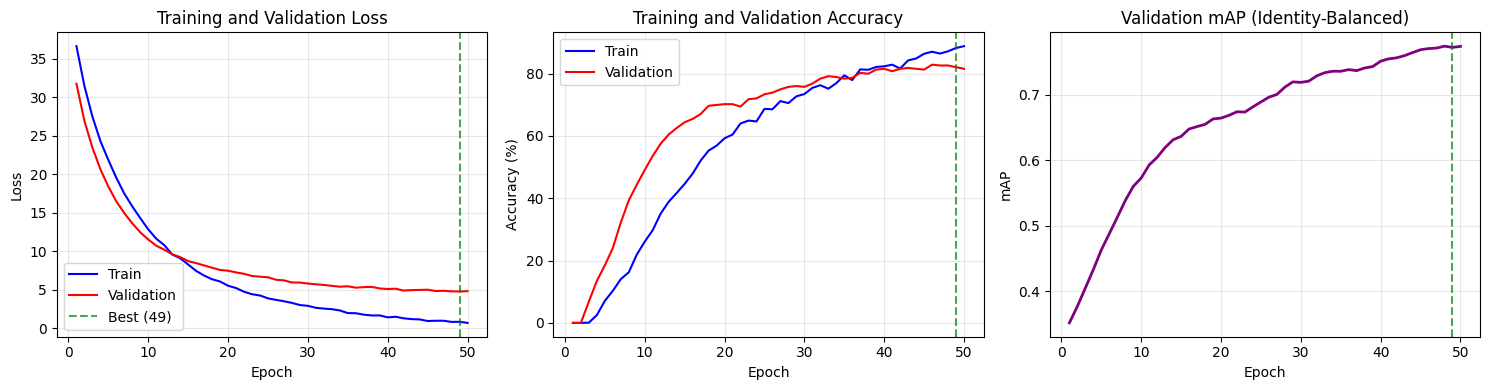

In [22]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

epochs_range = range(1, len(history['train_loss']) + 1)

# Loss
axes[0].plot(epochs_range, history['train_loss'], 'b-', label='Train')
axes[0].plot(epochs_range, history['val_loss'], 'r-', label='Validation')
axes[0].axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7, label=f'Best ({best_epoch})')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(epochs_range, history['train_acc'], 'b-', label='Train')
axes[1].plot(epochs_range, history['val_acc'], 'r-', label='Validation')
axes[1].axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# mAP
axes[2].plot(epochs_range, history['val_map'], 'purple', linewidth=2)
axes[2].axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('mAP')
axes[2].set_title('Validation mAP (Identity-Balanced)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config["checkpoint_dir"] / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Log to W&B
wandb.log({"training_curves": wandb.Image(fig)})

## 9. Visualize Fine-tuned Embeddings

After training, we visualize the fine-tuned embeddings using MDS and compare them to the baseline. We expect to see tighter clusters for each identity after ArcFace training.

In [23]:
# Load best model
checkpoint = torch.load(config["checkpoint_dir"] / "arcface_best.pth", map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']}")
print(f"  Val Loss: {checkpoint['val_loss']:.4f}")
print(f"  Val mAP: {checkpoint['val_map']:.4f}")

Loaded best model from epoch 49
  Val Loss: 4.7882
  Val mAP: 0.7726


In [24]:
# Extract fine-tuned embeddings for training data
model.eval()
with torch.no_grad():
    train_tensor = torch.FloatTensor(baseline_train_embeddings).to(device)
    finetuned_train_embeddings = model.get_embeddings(train_tensor).cpu().numpy()

print(f"Fine-tuned embeddings shape: {finetuned_train_embeddings.shape}")
print(f"Mean L2 norm: {np.linalg.norm(finetuned_train_embeddings, axis=1).mean():.4f}")

Fine-tuned embeddings shape: (1516, 256)
Mean L2 norm: 1.0000


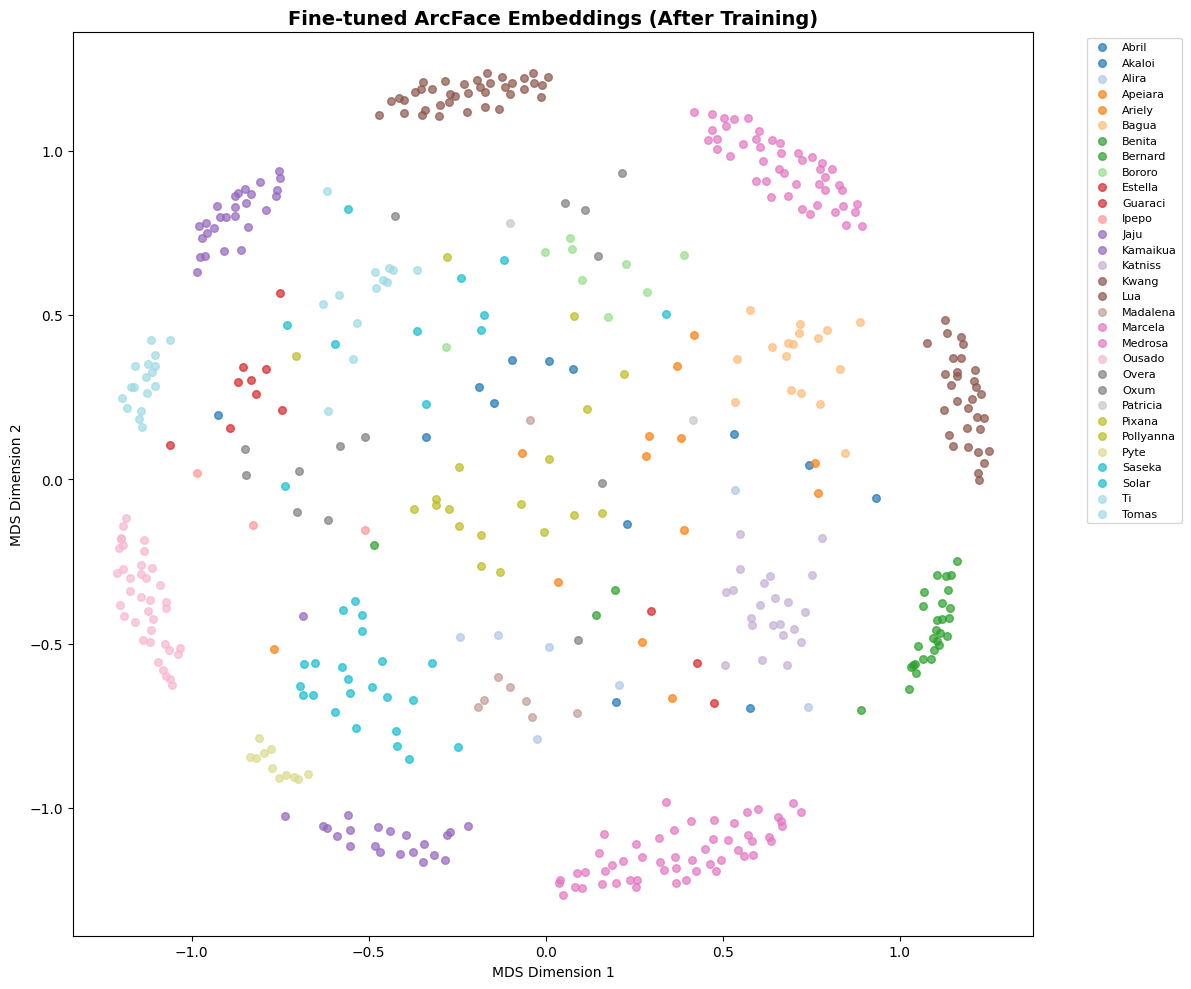

In [25]:
# Visualize fine-tuned embeddings
fig_finetuned = visualize_embeddings_mds(
    finetuned_train_embeddings,
    train_labels,
    "Fine-tuned ArcFace Embeddings (After Training)"
)
plt.show()

# Log to W&B
wandb.log({"finetuned_embeddings_mds": wandb.Image(fig_finetuned)})

In [26]:
def visualize_nearest_neighbors(
    query_idx,
    original_embeddings,
    finetuned_embeddings,
    image_paths,
    labels,
    k=5,
    title_prefix="Validation"
):
    """
    Visualize the k nearest neighbors of a query image before and after fine-tuning.
    
    Args:
        query_idx: Index of query image in the validation set
        original_embeddings: Original MegaDescriptor embeddings (N, D1)
        finetuned_embeddings: Fine-tuned embeddings (N, D2)
        image_paths: List of image file paths
        labels: Array of identity labels
        k: Number of nearest neighbors to show (default: 5)
        title_prefix: Prefix for the plot title
    
    Returns:
        fig: Matplotlib figure
        stats: Dictionary with comparison statistics
    """
    # Get query info
    query_label = labels[query_idx]
    query_path = image_paths[query_idx]
    
    # Normalize embeddings
    orig_norm = original_embeddings / np.linalg.norm(original_embeddings, axis=1, keepdims=True)
    fine_norm = finetuned_embeddings / np.linalg.norm(finetuned_embeddings, axis=1, keepdims=True)
    
    # Compute similarities (cosine similarity via dot product)
    orig_similarities = orig_norm @ orig_norm[query_idx]
    fine_similarities = fine_norm @ fine_norm[query_idx]
    
    # Find k+1 nearest neighbors (excluding self at position 0)
    orig_indices = np.argsort(-orig_similarities)[1:k+1]  # Skip self
    fine_indices = np.argsort(-fine_similarities)[1:k+1]  # Skip self
    
    # Get neighbor info
    orig_neighbors = {
        'indices': orig_indices,
        'labels': labels[orig_indices],
        'similarities': orig_similarities[orig_indices],
        'paths': [image_paths[i] for i in orig_indices],
        'correct': labels[orig_indices] == query_label
    }
    
    fine_neighbors = {
        'indices': fine_indices,
        'labels': labels[fine_indices],
        'similarities': fine_similarities[fine_indices],
        'paths': [image_paths[i] for i in fine_indices],
        'correct': labels[fine_indices] == query_label
    }
    
    # Calculate statistics
    stats = {
        'query_idx': query_idx,
        'query_label': query_label,
        'original_correct': int(orig_neighbors['correct'].sum()),
        'finetuned_correct': int(fine_neighbors['correct'].sum()),
        'improvement': int(fine_neighbors['correct'].sum() - orig_neighbors['correct'].sum())
    }
    
    # Create visualization
    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(2, k+1, hspace=0.3, wspace=0.3)
    
    # Row 1: Original embeddings
    # Query image (shared for both rows)
    ax_query_orig = fig.add_subplot(gs[0, 0])
    try:
        query_img = Image.open(query_path)
        ax_query_orig.imshow(query_img)
    except Exception as e:
        ax_query_orig.text(0.5, 0.5, f'Error loading\n{query_path.name}', 
                          ha='center', va='center')
    ax_query_orig.axis('off')
    ax_query_orig.set_title(f'QUERY\n{query_label}', fontsize=12, fontweight='bold', color='blue')
    # Add thick blue border for query
    for spine in ax_query_orig.spines.values():
        spine.set_edgecolor('blue')
        spine.set_linewidth(4)
    
    # Original neighbors
    for i, (idx, label, sim, path, correct) in enumerate(zip(
        orig_neighbors['indices'],
        orig_neighbors['labels'],
        orig_neighbors['similarities'],
        orig_neighbors['paths'],
        orig_neighbors['correct']
    )):
        ax = fig.add_subplot(gs[0, i+1])
        try:
            img = Image.open(path)
            ax.imshow(img)
        except Exception as e:
            ax.text(0.5, 0.5, f'Error loading\n{path.name}', ha='center', va='center')
        ax.axis('off')
        
        # Color-code by correctness
        color = 'green' if correct else 'red'
        match_symbol = '✓' if correct else '✗'
        
        ax.set_title(
            f'{match_symbol} {label}\nSim: {sim:.3f}',
            fontsize=10,
            color=color,
            fontweight='bold' if correct else 'normal'
        )
        
        # Add colored border
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3 if correct else 2)
    
    # Row 2: Fine-tuned embeddings
    # Query image (repeated for clarity)
    ax_query_fine = fig.add_subplot(gs[1, 0])
    try:
        query_img = Image.open(query_path)
        ax_query_fine.imshow(query_img)
    except Exception as e:
        ax_query_fine.text(0.5, 0.5, f'Error loading\n{query_path.name}', 
                          ha='center', va='center')
    ax_query_fine.axis('off')
    ax_query_fine.set_title(f'QUERY\n{query_label}', fontsize=12, fontweight='bold', color='blue')
    # Add thick blue border for query
    for spine in ax_query_fine.spines.values():
        spine.set_edgecolor('blue')
        spine.set_linewidth(4)
    
    # Fine-tuned neighbors
    for i, (idx, label, sim, path, correct) in enumerate(zip(
        fine_neighbors['indices'],
        fine_neighbors['labels'],
        fine_neighbors['similarities'],
        fine_neighbors['paths'],
        fine_neighbors['correct']
    )):
        ax = fig.add_subplot(gs[1, i+1])
        try:
            img = Image.open(path)
            ax.imshow(img)
        except Exception as e:
            ax.text(0.5, 0.5, f'Error loading\n{path.name}', ha='center', va='center')
        ax.axis('off')
        
        # Color-code by correctness
        color = 'green' if correct else 'red'
        match_symbol = '✓' if correct else '✗'
        
        ax.set_title(
            f'{match_symbol} {label}\nSim: {sim:.3f}',
            fontsize=10,
            color=color,
            fontweight='bold' if correct else 'normal'
        )
        
        # Add colored border
        for spine in ax.spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3 if correct else 2)
    
    # Add row labels
    fig.text(0.02, 0.75, 'BEFORE\nFine-Tuning\n(MegaDescriptor)', 
             fontsize=11, fontweight='bold', va='center', ha='center',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    fig.text(0.02, 0.25, 'AFTER\nFine-Tuning\n(ArcFace)', 
             fontsize=11, fontweight='bold', va='center', ha='center',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    
    # Add title with statistics
    fig.suptitle(
        f'{title_prefix}: Top-{k} Nearest Neighbors for Query "{query_label}"\n'
        f'Correct Matches - Before: {stats["original_correct"]}/{k} | '
        f'After: {stats["finetuned_correct"]}/{k} | '
        f'Improvement: {"+" if stats["improvement"] >= 0 else ""}{stats["improvement"]}',
        fontsize=14,
        fontweight='bold',
        y=0.98
    )
    
    return fig, stats

print("Nearest neighbors visualization function defined")

Nearest neighbors visualization function defined


In [27]:
# Visualize nearest neighbors for a few validation examples
# We'll pick a random sample and also manually select interesting cases

print("Generating nearest neighbor visualizations for validation set...")
print(f"Validation set size: {len(val_data)}")

# Get validation embeddings (we already have these)
# baseline_val_embeddings (original MegaDescriptor)
# val_finetuned_embeddings (fine-tuned with ArcFace)

# Extract fine-tuned embeddings for validation set if not already done
model.eval()
with torch.no_grad():
    val_tensor = torch.FloatTensor(baseline_val_embeddings).to(device)
    val_finetuned_embeddings = model.get_embeddings(val_tensor).cpu().numpy()

print(f"Original embeddings shape: {baseline_val_embeddings.shape}")
print(f"Fine-tuned embeddings shape: {val_finetuned_embeddings.shape}")

# Create list of validation image paths
val_labels = val_data['ground_truth'].values

# Build list of validation image paths
val_image_paths = [
    config["data_dir"] / "train" / filename 
    for filename in val_data['filename'].values
]

print(f"Number of validation images: {len(val_image_paths)}")

Generating nearest neighbor visualizations for validation set...
Validation set size: 379
Original embeddings shape: (379, 1536)
Fine-tuned embeddings shape: (379, 256)
Number of validation images: 379


Example 1: Random query (index 102)


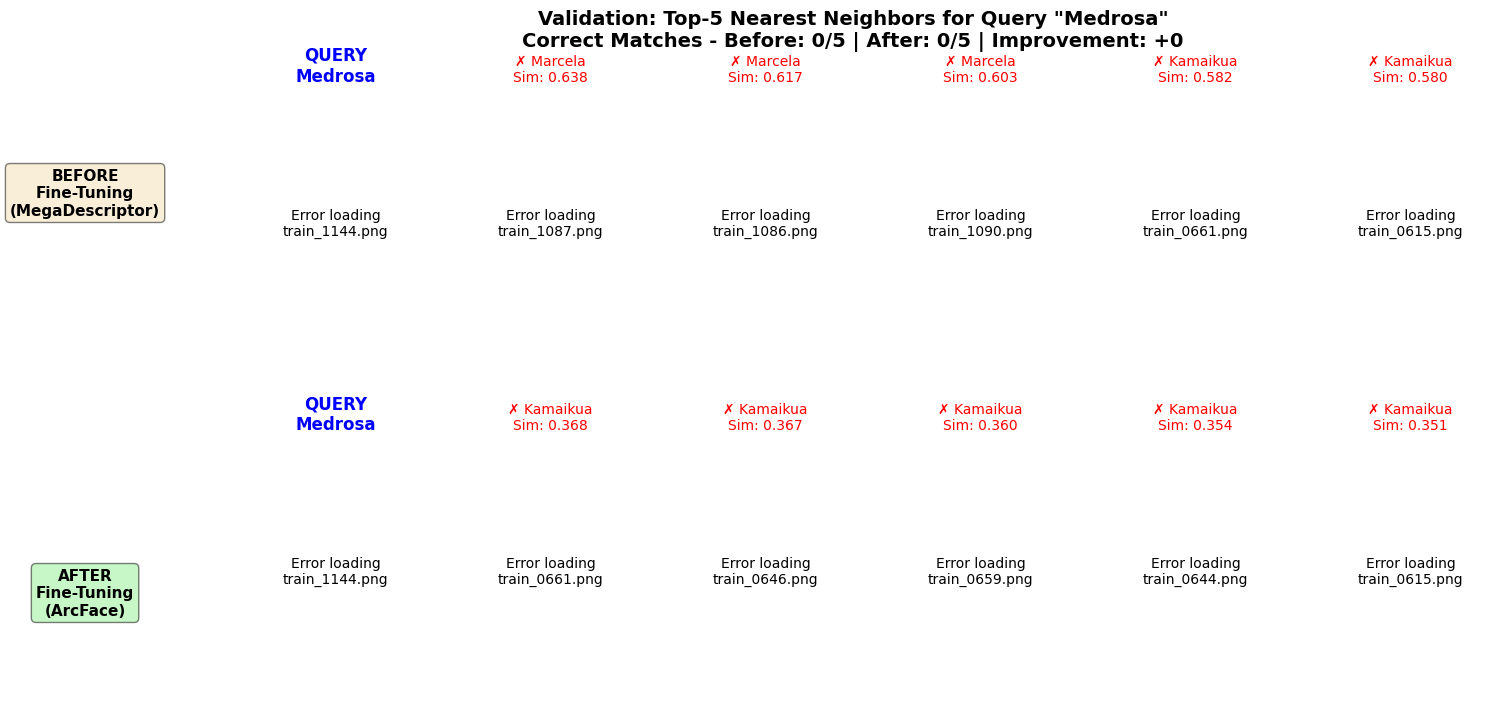

In [28]:
# Example 1: Random validation image
np.random.seed(RANDOM_SEED)
random_idx = np.random.randint(0, len(val_labels))

print(f"Example 1: Random query (index {random_idx})")
fig1, stats1 = visualize_nearest_neighbors(
    query_idx=random_idx,
    original_embeddings=baseline_val_embeddings,
    finetuned_embeddings=val_finetuned_embeddings,
    image_paths=val_image_paths,
    labels=val_labels,
    k=5
)
plt.show()

## 10. Generate Competition Submission

Now we generate predictions for the test set. The competition expects:
- A CSV with columns: `row_id`, `similarity`
- Each row corresponds to a query-gallery image pair from `test.csv`
- `similarity` is a float between 0 and 1

We:
1. Extract MegaDescriptor embeddings for all test images
2. Project through our fine-tuned model
3. Compute cosine similarity for each pair in `test.csv`
4. Clip values to [0, 1] and save as CSV

In [29]:
# Load test.csv to get the pairs we need to score
test_pairs_df = pd.read_csv(config["data_dir"] / "test.csv")

print(f"Test pairs to score: {len(test_pairs_df)}")
print(f"Columns: {list(test_pairs_df.columns)}")
print(f"\nSample rows:")
print(test_pairs_df.head())

Test pairs to score: 137270
Columns: ['row_id', 'query_image', 'gallery_image']

Sample rows:
   row_id    query_image  gallery_image
0       0  test_0001.png  test_0002.png
1       1  test_0001.png  test_0003.png
2       2  test_0001.png  test_0004.png
3       3  test_0001.png  test_0005.png
4       4  test_0001.png  test_0006.png


In [30]:
# Get unique test images
test_images = set(test_pairs_df['query_image'].unique()) | set(test_pairs_df['gallery_image'].unique())
test_images = sorted(list(test_images))

print(f"Unique test images: {len(test_images)}")

# Build paths
test_image_paths = [config["data_dir"] / "test/test" / filename for filename in test_images]

# Extract MegaDescriptor embeddings for test images
print(f"\nExtracting MegaDescriptor embeddings for test images...")
test_mega_embeddings = extract_embeddings(
    megadescriptor,
    test_image_paths,
    batch_size=config["batch_size"],
    desc="Test embeddings"
)

print(f"Test MegaDescriptor embeddings shape: {test_mega_embeddings.shape}")

Unique test images: 371

Extracting MegaDescriptor embeddings for test images...


Test embeddings:   0%|          | 0/12 [00:00<?, ?it/s]

Test MegaDescriptor embeddings shape: (371, 1536)


In [31]:
# Project through fine-tuned model
model.eval()
with torch.no_grad():
    test_tensor = torch.FloatTensor(test_mega_embeddings).to(device)
    test_finetuned_embeddings = model.get_embeddings(test_tensor).cpu().numpy()

print(f"Fine-tuned test embeddings shape: {test_finetuned_embeddings.shape}")
print(f"Mean L2 norm: {np.linalg.norm(test_finetuned_embeddings, axis=1).mean():.4f}")

# Create mapping from filename to embedding
img_to_embedding = {
    filename: embedding 
    for filename, embedding in zip(test_images, test_finetuned_embeddings)
}

Fine-tuned test embeddings shape: (371, 256)
Mean L2 norm: 1.0000


In [32]:
# Compute similarity for each pair
print("Computing pairwise similarities...")
similarities = []

for _, row in tqdm(test_pairs_df.iterrows(), total=len(test_pairs_df), desc="Computing similarities"):
    query_emb = img_to_embedding[row['query_image']]
    gallery_emb = img_to_embedding[row['gallery_image']]
    
    # Cosine similarity (embeddings are already normalized)
    sim = np.dot(query_emb, gallery_emb)
    similarities.append(sim)

# Clip to [0, 1] range
similarities = np.array(similarities)
similarities = np.clip(similarities, 0.0, 1.0)

print(f"\nSimilarity statistics:")
print(f"  Min: {similarities.min():.4f}")
print(f"  Max: {similarities.max():.4f}")
print(f"  Mean: {similarities.mean():.4f}")
print(f"  Std: {similarities.std():.4f}")

Computing pairwise similarities...


Computing similarities:   0%|          | 0/137270 [00:00<?, ?it/s]


Similarity statistics:
  Min: 0.0000
  Max: 0.9945
  Mean: 0.0623
  Std: 0.1244


In [33]:
# Create submission DataFrame
submission_df = pd.DataFrame({
    'row_id': test_pairs_df['row_id'],
    'similarity': similarities
})

print("Submission DataFrame:")
print(submission_df.head(10))

# Verify format matches sample submission
sample_submission = pd.read_csv(config["data_dir"] / "sample_submission.csv")
print(f"\nFormat check:")
print(f"  Expected columns: {list(sample_submission.columns)}")
print(f"  Our columns: {list(submission_df.columns)}")
print(f"  Expected rows: {len(sample_submission)}")
print(f"  Our rows: {len(submission_df)}")

Submission DataFrame:
   row_id  similarity
0       0    0.632173
1       1    0.000000
2       2    0.000000
3       3    0.000000
4       4    0.000000
5       5    0.028567
6       6    0.015650
7       7    0.049369
8       8    0.000000
9       9    0.000000

Format check:
  Expected columns: ['row_id', 'similarity']
  Our columns: ['row_id', 'similarity']
  Expected rows: 137270
  Our rows: 137270


In [34]:
# Save submission
submission_path = config["checkpoint_dir"] / "submission.csv"
submission_df.to_csv(submission_path, index=False)

print(f"Submission saved to: {submission_path}")
print(f"File size: {submission_path.stat().st_size / 1024:.1f} KB")

Submission saved to: checkpoints/submission.csv
File size: 1814.1 KB


## 11. Save Artifacts to Weights and Biases

We save the best model checkpoint and this notebook as W&B artifacts for reproducibility.

In [35]:
# Save model as W&B artifact
model_artifact = wandb.Artifact(
    name="arcface-model",
    type="model",
    description="ArcFace fine-tuned MegaDescriptor model for jaguar re-identification"
)
model_artifact.add_file(str(config["checkpoint_dir"] / "arcface_best.pth"))
wandb.log_artifact(model_artifact)

print("Model artifact saved to W&B")

Model artifact saved to W&B


In [36]:
# Save submission as W&B artifact
submission_artifact = wandb.Artifact(
    name="submission",
    type="submission",
    description="Competition submission file"
)
submission_artifact.add_file(str(submission_path))
wandb.log_artifact(submission_artifact)

print("Submission artifact saved to W&B")

Submission artifact saved to W&B


In [37]:
# Finish W&B run
wandb.finish()

print("W&B run completed")

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
num_identities,▁
train_acc,▁▁▁▁▂▂▂▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████
train_loss,█▇▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_samples,▁
val_acc,▁▁▂▂▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████
val_loss,█▇▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_map,▁▁▂▃▃▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
val_samples,▁
best_epoch,49


W&B run completed


## Summary

This notebook demonstrated a complete pipeline for jaguar re-identification:

1. **Data Preparation**: Loaded training data and created a stratified train/validation split ensuring all identities appear in both sets.

2. **Baseline Embeddings**: Extracted 1536-dimensional embeddings using MegaDescriptor-L-384, a vision transformer pre-trained for wildlife re-identification.

3. **ArcFace Training**: Fine-tuned embeddings using ArcFace loss, which optimizes angular distances on a hypersphere. This encourages embeddings of the same jaguar to cluster together.

4. **Visualization**: Used MDS to project embeddings to 2D, comparing baseline vs fine-tuned representations.

5. **Submission**: Generated predictions by computing cosine similarity between fine-tuned embeddings for all test pairs.

**Key Hyperparameters**:
- ArcFace margin: 0.5 (adds 28.6 degrees angular penalty)
- ArcFace scale: 64 (controls softmax sharpness)
- Embedding dimension: 256 (projected from 1536)
- Learning rate: 1e-4 with ReduceLROnPlateau scheduler

**Next Steps**:
- Experiment with different margins and scales
- Try data augmentation during training
- Ensemble multiple models
- Fine-tune the MegaDescriptor backbone (more compute required)